## Model Training and Model Evaluation

In [1]:
# -------------------- IMPORTS --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib

# Reproducibility
RANDOM_STATE = 27


In [3]:
df = pd.read_csv("cleaned_dataset.csv")
df

,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,pulse_pressure,health_index,cardio
0,2,62.0,110,80,1,1,0,0,1,50,21.967120,30,0,0
1,1,85.0,140,90,3,1,0,0,1,55,34.927679,50,1,1
2,1,64.0,130,70,3,1,0,0,0,51,23.507805,60,2,1
3,2,82.0,150,100,1,1,0,0,1,48,28.710479,50,0,1
4,1,56.0,100,60,1,1,0,0,0,47,23.011177,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69971,2,76.0,120,80,1,1,1,0,1,52,26.927438,40,1,0
69972,1,126.0,140,90,2,2,0,0,1,61,50.472681,50,2,1
69973,2,105.0,180,90,3,1,0,1,0,52,31.353579,90,3,1
69974,1,72.0,135,80,1,2,0,0,0,61,27.099251,55,2,1


In [5]:
target = 'cardio'
features = [col for col in df.columns if col != target]

In [7]:
X = df[features]
y = df[target]
X.shape, y.shape


((69976, 13), (69976,))

In [9]:
# Train-test split (90% train, 10% test) with stratification for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


In [11]:
# -------------------- 1. DEFINE MULTIPLE MODELS (Pipeline + StandardScaler for convergence) --------------------
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)),
    ]),
    "Decision Tree": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
    ]),
    "K-Nearest Neighbors": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5)),
    ]),
}


In [13]:
# -------------------- 2. TRAIN ALL MODELS & EVALUATE --------------------
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    """Train model and return metrics: accuracy, precision, recall, f1, confusion_matrix, roc_auc."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None
    return {
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_te, y_pred),
        "roc_auc": roc_auc_score(y_te, y_proba) if y_proba is not None else 0.0,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "model": model,
    }

model_results = {}
for name, model in models.items():
    model_results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name}: Accuracy={model_results[name]['accuracy']:.4f}, ROC-AUC={model_results[name]['roc_auc']:.4f}")

Logistic Regression: Accuracy=0.7171, ROC-AUC=0.7798
Decision Tree: Accuracy=0.6400, ROC-AUC=0.6413
Random Forest: Accuracy=0.7038, ROC-AUC=0.7609
K-Nearest Neighbors: Accuracy=0.6562, ROC-AUC=0.7002


In [15]:
# -------------------- 3. MODEL COMPARISON TABLE --------------------
comparison_df = pd.DataFrame({
    name: {
        "Accuracy": res["accuracy"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1 Score": res["f1"],
        "ROC-AUC": res["roc_auc"],
    }
    for name, res in model_results.items()
}).T
comparison_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.717062,0.739467,0.669907,0.702970,0.779806
Decision Tree,0.639969,0.645406,0.620586,0.632753,0.641261
Random Forest,0.703844,0.708761,0.691637,0.700094,0.760900
K-Nearest Neighbors,0.656187,0.665104,0.628592,0.646333,0.700197


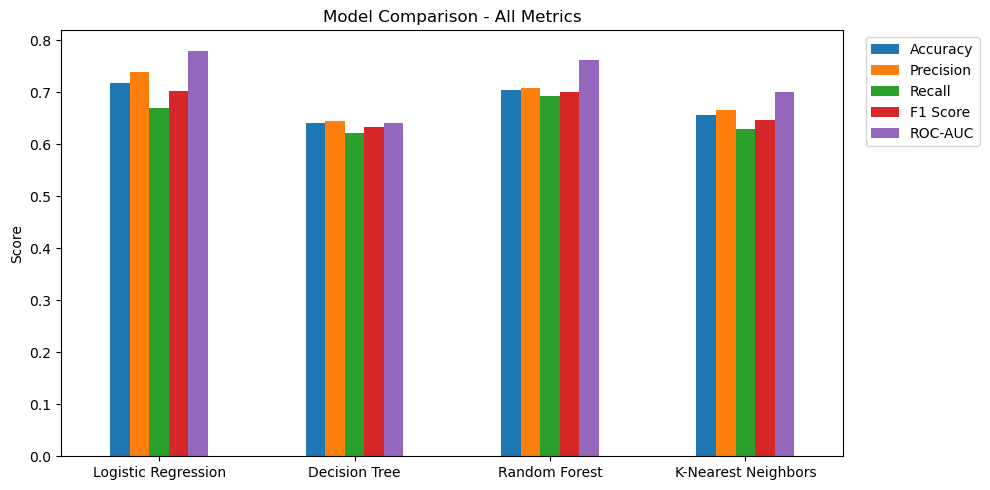

In [17]:
# -------------------- 4. MODEL COMPARISON BAR CHART --------------------
comparison_df.plot(kind="bar", figsize=(10, 5), rot=0)
plt.title("Model Comparison - All Metrics")
plt.ylabel("Score")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [19]:
# -------------------- 5. 5-FOLD CROSS VALIDATION --------------------
cv_scores = {}
for name, res in model_results.items():
    model = res["model"]
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    cv_scores[name] = scores
    print(f"{name}: Fold scores = {scores.round(4)}, Mean CV = {scores.mean():.4f}")

Logistic Regression: Fold scores = [0.7136 0.7237 0.7172 0.7278 0.7164], Mean CV = 0.7197
Decision Tree: Fold scores = [0.6304 0.6438 0.6417 0.643  0.6357], Mean CV = 0.6389
Random Forest: Fold scores = [0.7055 0.7143 0.7079 0.7081 0.7019], Mean CV = 0.7075
K-Nearest Neighbors: Fold scores = [0.6575 0.6732 0.6615 0.6698 0.6568], Mean CV = 0.6638


In [21]:
# -------------------- 6. HYPERPARAMETER TUNING (RandomizedSearchCV - fast) FOR RANDOM FOREST --------------------
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
])
param_dist = {
    "clf__n_estimators": [50, 100, 150],
    "clf__max_depth": [8, 12, None],
    "clf__min_samples_split": [2, 5],
    "clf__max_features": ["sqrt", "log2"],
}
# n_iter=8 × cv=2 = 16 fits (much faster than full grid)
random_search = RandomizedSearchCV(
    rf_pipeline, param_dist, n_iter=8, cv=2, scoring="accuracy",
    n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
best_rf = random_search.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__max_features': 'log2', 'clf__max_depth': 12}
Best CV score: 0.7351375491246874


In [23]:
# -------------------- 7. BEST MODEL: TRAIN VS TEST ACCURACY & OVERFITTING CHECK --------------------
best_model = best_rf
train_acc = accuracy_score(y_train, best_model.predict(X_train))
test_acc = accuracy_score(y_test, best_model.predict(X_test))
cv_mean = cross_val_score(best_model, X, y, cv=5, scoring="accuracy").mean()
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"5-Fold CV Mean:    {cv_mean:.4f}")
gap = train_acc - test_acc
if gap > 0.1:
    print("Diagnosis: Possible OVERFITTING (train accuracy >> test accuracy)")
elif test_acc - train_acc > 0.05:
    print("Diagnosis: Possible UNDERFITTING (model may be too simple)")
else:
    print("Diagnosis: Generalization looks reasonable")

Training Accuracy: 0.7723
Testing Accuracy:  0.7310
5-Fold CV Mean:    0.7360
Diagnosis: Generalization looks reasonable


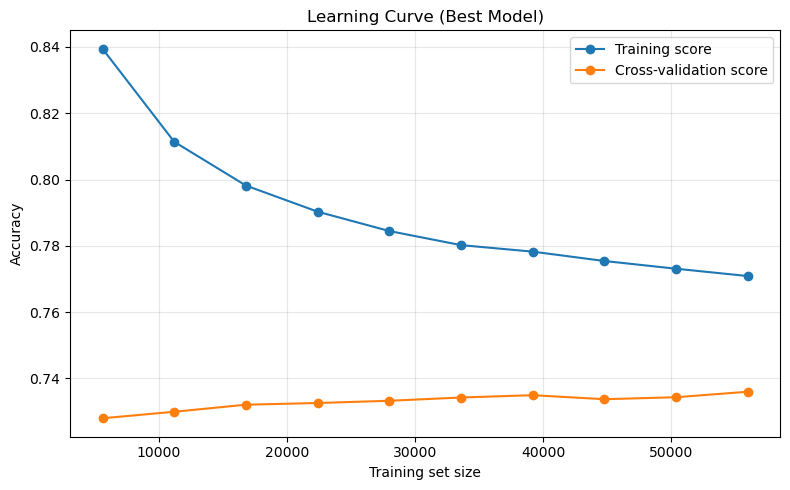

In [25]:
# -------------------- 9. LEARNING CURVE --------------------
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, "o-", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", label="Cross-validation score")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Best Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

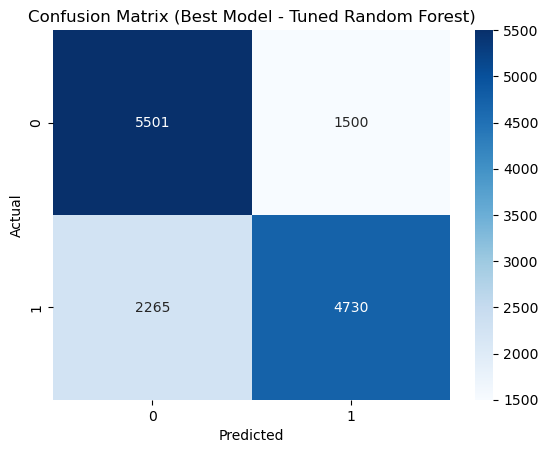

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      7001
           1       0.76      0.68      0.72      6995

    accuracy                           0.73     13996
   macro avg       0.73      0.73      0.73     13996
weighted avg       0.73      0.73      0.73     13996



In [29]:
# -------------------- 8. CONFUSION MATRIX (BEST MODEL) --------------------
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Best Model - Tuned Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, y_pred_best))

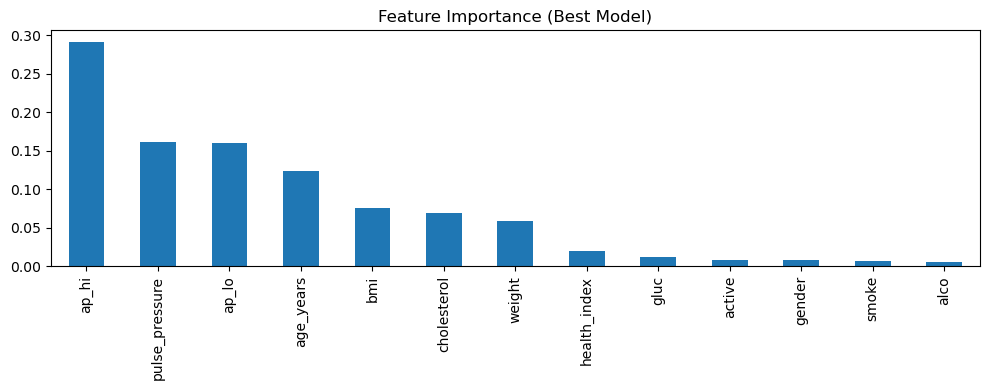

In [31]:
# -------------------- 10. FEATURE IMPORTANCE (BEST MODEL) --------------------
# Best model is a Pipeline; get the Random Forest step for feature_importances_
clf = best_model.named_steps["clf"] if hasattr(best_model, "named_steps") else best_model
feature_importance = pd.Series(
    clf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)
feature_importance.plot(kind="bar", figsize=(10, 4))
plt.title("Feature Importance (Best Model)")
plt.tight_layout()
plt.show()

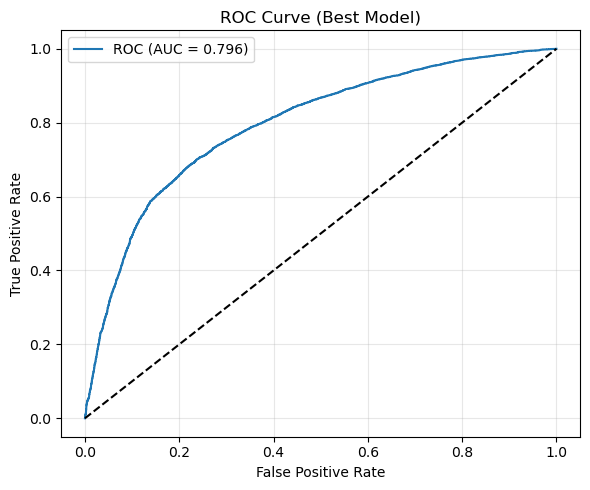

In [33]:
# -------------------- 11. ROC CURVE (BEST MODEL) --------------------
y_proba_best = best_model.predict_proba(X_test)[:, 1]
roc_fpr, roc_tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
plt.figure(figsize=(6, 5))
plt.plot(roc_fpr, roc_tpr, label=f"ROC (AUC = {roc_auc_best:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Save the model on disk

In [36]:
# -------------------- PHASE 2: SAVE EVERYTHING TO cardio_model.pkl --------------------
feature_columns = list(X_train.columns)
feature_importance_dict = feature_importance.to_dict()

artifact = {
    "model": best_model,
    "columns": feature_columns,
    "train_accuracy": train_acc,
    "test_accuracy": test_acc,
    "cv_score": cv_mean,
    "feature_importance": feature_importance_dict,
    "roc_fpr": roc_fpr,
    "roc_tpr": roc_tpr,
    "learning_curve": {
        "train_sizes": train_sizes.tolist(),
        "train_scores_mean": train_scores_mean.tolist(),
        "test_scores_mean": test_scores_mean.tolist(),
    },
    "model_comparison": comparison_df.to_dict("index"),
}
joblib.dump(artifact, "cardio_model.pkl")
print("Saved to cardio_model.pkl:", list(artifact.keys()))


Saved to cardio_model.pkl: ['model', 'columns', 'train_accuracy', 'test_accuracy', 'cv_score', 'feature_importance', 'roc_fpr', 'roc_tpr', 'learning_curve', 'model_comparison']
